In [59]:
using DrWatson
quickactivate(@__DIR__)

using NetHeider
using LinearAlgebra
using LightGraphs
using Plots
using DataFrames
using JLD2
using Statistics

include(projectdir("scripts", "notebooks_netsense_funs.jl"))

show_res (generic function with 1 method)

In [5]:
res = jldopen(datadir("sims7", "collected_results.jld2")) do file
    file["res"]
end;

From the NetSense dataset we may obtain transitions. And we can also obtain the proper results for node- and edge randomizations. 

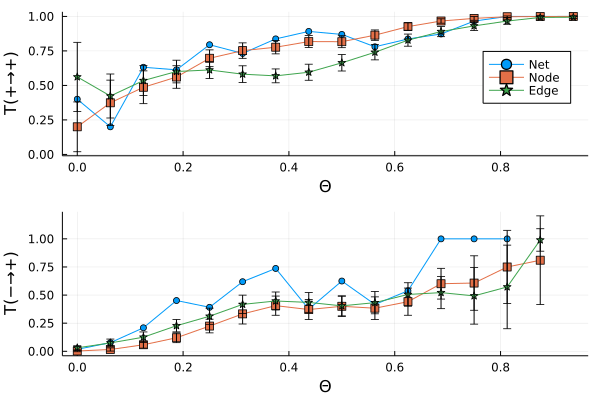

In [13]:
real_trans_df = jldopen(datadir("exp_pro", "real_randomized_triad_trans_results.jld2")) do file
    file["res"]
end

xvals = real_trans_df.threshold
p1 = plot(xvals, real_trans_df.netsense_b2b, 
    markershape = :circle, label = "Net", legend = :right)#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_b2b, yerror = real_trans_df.node_rand_b2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_b2b, yerror = real_trans_df.edge_rand_b2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)

markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
p2 = plot(legend = false)

plot!(xvals, real_trans_df.netsense_u2b, 
    markershape = :circle, label = "Net")#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_u2b, yerror = real_trans_df.node_rand_u2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_u2b, yerror = real_trans_df.edge_rand_u2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)


ylabel!("T(−→+)")

plot(p1, p2, layout = (2,1))
xlabel!("Θ")

I will just remind that transition results for NetSense data is the same as previously. The results for node- and edge randomizations gives different result than previously. 

So as we can see edge randomization gives poor results. Node randomization gives quite good results for $T(+\to+)$, but poor results (even worse than edge) for $T(-\to+)$. 

Could one conclude that we have random changes and changes that resolve conflicts already from this figure? 

## Rationale for current results. 

I have tested following sets of parameters:

1. adding link ratio: after every step (ES) or only after picking unbalanced triad (PUT)
2. adding link prob to close triad: 0 (random adding), 0.35 (with this prob a triad surely will be closed)
3. padd: for ES: up to 0.1, for PUT: up to 0.3
4. pn: [0, 0.2, ..., 1]
5. pr_neg=pr_pos: [0.05, 0.10, ..., 0.3]

The important question is where to stop the results. It seems the most natural to check the results after each triad could be picked 3 times, so each node may be changed at least once because of the given triad it is is. The initial network is always a network from term 1. This gives 45 triads, and therefore, 45*3=135 steps. 

Example result compared to data from NetSense:

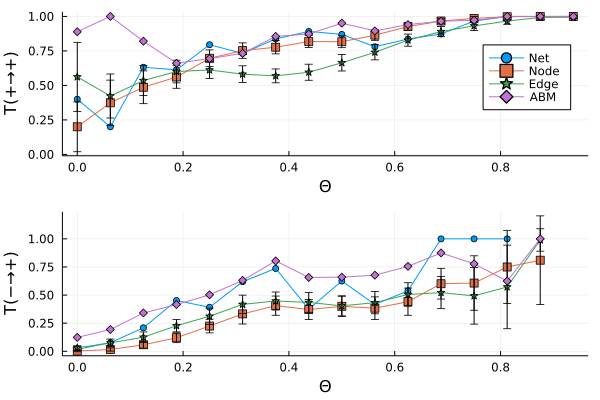

In [25]:
# parameters
pn = 0.2
pclose_triad = 0.
pr_pos = pr_neg = 0.05
padd = 0.01
threshold = [0:15...]/16

time_step = 135
time_ind = Int(time_step / 5)

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

xvals = real_trans_df.threshold
p1 = plot(xvals, real_trans_df.netsense_b2b, 
    markershape = :circle, label = "Net", legend = :right)#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_b2b, yerror = real_trans_df.node_rand_b2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_b2b, yerror = real_trans_df.edge_rand_b2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)
plot!(xvals, b2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)

markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
p2 = plot(legend = false)

plot!(xvals, real_trans_df.netsense_u2b, 
    markershape = :circle, label = "Net")#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_u2b, yerror = real_trans_df.node_rand_u2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_u2b, yerror = real_trans_df.edge_rand_u2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)
plot!(xvals, u2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)


ylabel!("T(−→+)")

plot(p1, p2, layout = (2,1))
xlabel!("Θ")

# title!("pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01")

Parameters:
(links added after each step)
pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01

As we can see above (and this is repeatable for each plot) that ABM model gets very poor results for very small $\Theta$. This is very big difference as compared to the previous result. Do you have any comment on that? I will just add that for the model with links added after picking a balanced triad it is the same. 

How can we compare different results? I have proposed 4 metrics, each of them based on the following formula:
$$ Err = \sum_\Theta f(T_\pm(\Theta),\hat{T}_\pm(\Theta))$$
It means that we sum over two curves $T(\pm\to+)$ for each $\Theta$ we calculate specific error function $f$ value. Considered error functions are:
1. mean squared error (MSE), i.e. $(T_\pm(\Theta)-\hat{T}_\pm(\Theta))^2$
2. mean absolute error (MAE), i.e. $|T_\pm(\Theta)-\hat{T}_\pm(\Theta)|$ 
3. MSE excluding 3 smallest $\Theta$ values
4. MAE excluding 3 smallest $\Theta$ values

Excluding 3 smallest values seems reasonable for me. One of the reasons is that those threshold values are explained by the random static models. 
Also, I wouldn't be surprized that having a given network structure it is very unlikely to change a balanced triad (which are very rare) having small threshold. Maybe I should start simulations from different terms, not only term 1?

### Error values for node and edge randomizations. 

In [28]:
mse = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(0.9327230755126914, 3.908759190827624, 0.8146233317693982, 3.1628818989844203)

In [29]:

mse = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(1.257523772472556, 4.379225839404921, 1.1650954074853879, 3.798715754039451)

As we can see node randomization gives better overall results. 

Let us now see the results from simulations. As mentioned previously, I have tested a wide variety of parameters. For each of them I calculated error bars and chosen 10 best ones. The obtained error values are as follows. 

In [40]:
fname = datadir("exp_pro", "sim_add_each_turn_compared_to_rl_sims7.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end

    calc_errors = false
else
    calc_errors = true
end

#finding 10 best param sets
proper_time = 135
proper_inds = results_df.time_ind .== proper_time/5
partial_results_df = results_df[proper_inds, :]

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(partial_results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = partial_results_df[inds2, col]
end
mulinds
valinds

4×10 Matrix{Float64}:
 1.42887   1.4347    1.47279   1.48143   …  1.5882    1.59477   1.59664
 3.98636   4.07543   4.11299   4.15944      4.28402   4.32799   4.36074
 0.471733  0.496511  0.590588  0.619203     0.672082  0.678537  0.683263
 2.32621   2.41559   2.48345   2.49739      2.55115   2.57844   2.61926

The obtained error values for MAE and MSE including 3 smallest $\Theta$ give larger results. But excluding these points we see that ABM gets better transition values than random models. 

Let us see what parameters lead to the smallest errors. 

In [62]:
display(mulinds)

pn = unique(res.pn)
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

show_res(partial_results_df, dicts, 6)
show_res(partial_results_df, dicts, 40)
show_res(partial_results_df, dicts, 36)

4×10 Matrix{Int64}:
  6  36  35  40  11  160   50  62   46    8
 40  35  36   6  39    8   10  11  160   50
  6  62  36  11  35  247  160  40  284  107
  6  40  62  36  35   39  160  11    8   10

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

To summarize. 

Overall, the best results were obtained with the following parameters. 

* Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)

Slightly worse were for:

* Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)
* Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)

Adding or removing edges doesn't matter much. The most importand seems low value of pn. 

1. Results for the PUT
2. Calibrating parameters - problem with pr, how to calibrate it?
3. Calibrating pn
4. Results for Dyad Model

## Results for the model with adding leans after picking unbalanced triad (PUT)

Now let me check similar error values for the PUT model. 

In [65]:
res = jldopen(datadir("sims_add_unbalanced2", "collected_results.jld2")) do file
    file["res"]
end;

fname = datadir("exp_pro", "sim_add_unbalanced_compared_to_rl2.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    # display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end;

pn = unique(res.pn)
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

#finding 10 best param sets
proper_time = 135
proper_inds = results_df.time_ind .== proper_time/5
partial_results_df = results_df[proper_inds, :]

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(partial_results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = partial_results_df[inds2, col]
end
mulinds
valinds

,padd,pr_neg,pn,pclose_triad,pr_pos,dict_ind,time_ind,mse,mae
,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,0.01,0.05,0.0,0.0,0.05,1,9.0,2.87058,5.77008
2,0.01,0.05,0.0,0.0,0.05,1,18.0,1.98305,4.63651
3,0.01,0.05,0.0,0.0,0.05,1,27.0,1.67096,4.51065


4×10 Matrix{Float64}:
 1.3562    1.49908   1.50631   1.51198   …  1.57791   1.59504  1.60517
 4.05092   4.12398   4.13964   4.18188      4.31866   4.32978  4.33087
 0.542751  0.543265  0.574993  0.597959     0.689995  0.69237  0.717746
 2.38329   2.44708   2.47497   2.53057      2.71001   2.72129  2.73716

Apart from the first result for MSE, for all other 3 error metrics PUT gives slightly worse results. They are still better than node- or edge randomization when we exclude 3 smallest thresholds. 

In [68]:
display(mulinds)

pn = unique(res.pn)
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

show_res(partial_results_df, dicts, 8)
show_res(partial_results_df, dicts, 74)
show_res(partial_results_df, dicts, 1)

4×10 Matrix{Int64}:
 74   8    5  239  118  115  73   96  103   68
  8  74   73  118  103    5  85   34   93   78
  1  74  131    8   96   73   5  306   85  220
  8   1   74   73   96    5  85  103   11  131

"Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.13, \"pr_neg\" => 0.0, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.0)"

"135.0"

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.0, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"135.0"

Overall, the best results were obtained with the following parameters. 

* Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)
* Dict(\"padd\" => 0.13, \"pr_neg\" => 0.0, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.0)

Slightly worse was:

* Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.0, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)

Here, the results are not so conclusive. We can only say that result for pn tend to be smaller than bigger. Perhaps more repetitions are needed to obtain a better statistics. 

# Calibrating parameters
## pr

From real data i obtained that 
$$V / (V + A) \approx 0.2,$$
where V is the number of vanishing edges and A - the number of changes in the attributes. 

But is this value a proper result? Is this a proper calibration method? I am not sure. 

## pn
I calculated the number of triads that were $++-$ and changed their state or were turned into a wedge structure (triad without one link missing; so like one link was removed) for each threshold seperately. I obtained these numbers for each threshold:

``` NaN
 NaN
   1.0
   1.0
   0.6
   0.5
   0.5454545454545454
   0.5
   0.3333333333333333
   0.7142857142857143
   1.0
   1.0
   1.0
   1.0
 NaN
 NaN
 ```

 It means that for 2 smallest and 2 largest threshold there wasn't a proper change of triad $++-$. The number of these changes is the largest for the medium thresholds, which can be seen in the following result. I summed up all the changes together, no matter the threshold value, and obtained $p_n\approx0.397$, while the normal average of above values gives $p_n\approx0.766$. 

 I also verified that for $\Theta=0$, $p_n$ doesn't change the ABM simulation results (whereas for the medium threshold it is a very significant parameter). 

 So I decided to check ABM best results if we assume $p_n=0.4$. 

## Assuming pn=0.4

In [76]:
res = jldopen(datadir("sims7", "collected_results.jld2")) do file
    file["res"]
end;

fname = datadir("exp_pro", "sim_add_each_turn_compared_to_rl_sims7_pn0_4.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    # display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end;

pn = [0.4]
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

#finding 10 best param sets
proper_time = 135
proper_inds = results_df.time_ind .== proper_time/5
partial_results_df = results_df[proper_inds, :]

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(partial_results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = partial_results_df[inds2, col]
end
mulinds
valinds

4×10 Matrix{Float64}:
 1.51404   1.60669   1.61208   1.63945   …  1.81439   1.8476    1.91861
 4.28402   4.36784   4.38353   4.40836      4.79458   4.90318   4.91516
 0.619203  0.678537  0.737851  0.743614     0.940516  0.954255  0.978602
 2.55115   2.72038   2.75058   2.8655       3.08286   3.08496   3.08733

In [77]:
display(mulinds)

# pn = unique(res.pn)
# pclose_triad = unique(res.pclose_triad)
# pr_pos = pr_neg = unique(res.pr_pos)
# padd = unique(res.padd)
# threshold = [0:15...]/16

# time_points = [45, 90, 135, 180, 270]
# time_inds = Int.(time_points ./ 5)

# strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
# dicts = dict_list(strdicts)

show_res(partial_results_df, dicts, 1)
show_res(partial_results_df, dicts, 7)
show_res(partial_results_df, dicts, 8)

4×10 Matrix{Int64}:
 1   8  7   2  20  49  10   4  28  23
 1   8  2   7  10  28   4  20  24  26
 1  49  7  20   8   2  23  10  28  43
 1   7  8   2  20  16  10  28  49  24

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.03, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

To summarize. 

Overall, clearly the best result was obtained with the following parameters. 

* Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)

Slightly worse were:

* Dict(\"padd\" => 0.03, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)
* Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)

Looking at the previous result for ES, apart for pn, we have the same parameters. And the more edges are added the worse are the results. 

## pn=0.4 for PUT

In [78]:
res = jldopen(datadir("sims_add_unbalanced2", "collected_results.jld2")) do file
    file["res"]
end;

fname = datadir("exp_pro", "sim_add_unbalanced_compared_to_rl2_pn0_4.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    # display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end;

pn = [0.4]
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

#finding 10 best param sets
proper_time = 135
proper_inds = results_df.time_ind .== proper_time/5
partial_results_df = results_df[proper_inds, :]

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(partial_results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = partial_results_df[inds2, col]
end
mulinds
valinds

4×10 Matrix{Float64}:
 1.3562    1.57069   1.59504   1.65429   …  1.69508   1.76895   1.81246
 4.12398   4.13964   4.20533   4.50642      4.56944   4.57005   4.6364
 0.543265  0.574993  0.642957  0.733829     0.845322  0.846693  0.84889
 2.47497   2.53057   2.71001   2.72129      2.87722   2.88224   2.88555

In [80]:
display(mulinds)

show_res(partial_results_df, dicts, 14)
show_res(partial_results_df, dicts, 13)

4×10 Matrix{Int64}:
 14  13  18  38  39   1   6   3   5  21
 14  13  18  10   1   3   6   9  20   5
 14  21  13  39  23   1   3  38   6  18
 14  13  18   1  21  10  39  33   3  15

"Dict(\"padd\" => 0.13, \"pr_neg\" => 0.0, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.0)"

"135.0"

"Dict(\"padd\" => 0.09, \"pr_neg\" => 0.0, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.0)"

"135.0"

To summarize. 

Overall, clearly the best result was obtained with the following parameters. 

* Dict(\"padd\" => 0.13, \"pr_neg\" => 0.0, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.0)

Slightly worse was:

* Dict(\"padd\" => 0.09, \"pr_neg\" => 0.0, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.0)

Of course, the best result here was the best overall, so it is shown here. Don't we need to remove edges at all?

## Running NetSense on DyadHomophilic ABM model

Pham et al. published a paper in PNAS, 2021 stating that dyadic interactions are enough to explain structural balance observations. Therefore, I decided to run their model on NetSense.

Their model is a quasi-Metropolis algorithm with defined Hamiltonian with two parameters: 
* $\alpha$ - parameter for controlling homophilic and heterophobic relations, that is how much (dis)similar agents want to (dis)like each other. For $\alpha=1$, we have only homophilic relations, for $\alpha=0.5$ these two factors have the same strength.
* $\beta$ - standard inverse temperature parameter

I have assumed that the macro-step will consists of $N$ (number of agents), so as after it each agent will be changed 1 on average. 
(In the first term $N=98$.)

In [107]:
valinds

4×10 Matrix{Float64}:
 1.36886   1.51404  1.60669   1.61208   …  1.71269   1.7203    1.74623
 4.17225   4.28402  4.36784   4.38353      4.52926   4.5329    4.54022
 0.619203  0.66408  0.678537  0.688076     0.754086  0.798662  0.801204
 2.55115   2.62331  2.72038   2.75058      2.88813   2.8934    2.89721

In [108]:
function show_res(df::DataFrame, dicts, num)
    display(string(dicts[results_df[num, :dict_ind]]))
    display(string(results_df[num, :time_ind]*5))
end

show_res(results_df, dicts, 3)
show_res(results_df, dicts, 49)
show_res(results_df, dicts, 33)
show_res(results_df, dicts, 38)


"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"180.0"

"Dict(\"padd\" => 0.03, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

# Calculating error for edge and node randomization

In [30]:
real_trans_df

mse = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(0.9327230755126914, 3.908759190827624, 0.8146233317693982, 3.1628818989844203)

In [31]:

mse = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(1.257523772472556, 4.379225839404921, 1.1650954074853879, 3.798715754039451)

Apart from the error for MSE the results for ABM give better approximation of the transition probabilities. 

## Triad balanced triads density

In [38]:
dicts

2940-element Vector{Dict{String, Float64}}:
 Dict("padd" => 0.01, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.03, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.05, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.07, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.09, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.01, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.03, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.05, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.07, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.09, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 ⋮
 Dict("padd" => 0.

In [ ]:
function plot_dict(dicts, df, param_ind)

    dict = dicts[results_df[param_ind, :dict_ind]]
    cropped_res = get_part_dataframe(res, dict)

    time_ind = Int(results_df[param_ind, :time_ind])
    xvals = cropped_res[:, :threshold]
    b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
    u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

    p1 = plot(xvals, b2b_vals, markershape = markers[1], label = "ABM T(+->+)")#, linestyle = :none)
    plot!(p1, xvals, u2b_vals, markershape = markers[2], label = "ABM T(-->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_b2b, markershape = markers[3], label = "Net T(+->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_u2b, markershape = markers[4], label = "Net T(-->+)")#, linestyle = :none)
    title!(p1, "steps="*string(10*time_ind))
    
    return p1
end

p1 = plot_dict(dicts, results_df, 665)
# title!(p1, string(dicts[results_df[665, :dict_ind]]))
display(string(dicts[results_df[665, :dict_ind]]))
p2 = plot_dict(dicts, results_df, 60)
display(string(dicts[results_df[60, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])
p3 = plot_dict(dicts, results_df, 1481)
display(string(dicts[results_df[1481, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])

plot!(p1, legend = :outertopright)
plot!(p1, legend = :outerbottom)
plot!(p2, legend = false)
plot!(p3, legend = false)

plot(p1, p2, p3, layout = (1,3))

## Influence of different pn values for specific theta

In [121]:
threshold = [8] / 16
pn = [0.]

# parameters
# pn = [0.8]
# pclose_triad = unique(res.pclose_triad)
# pr_pos = pr_neg = unique(res.pr_pos)
# padd = unique(res.padd)
# threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict  threshold#padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

dict = dicts[1]

cropped_res = get_part_dataframe(res, dict; verbose =false)

nrow(cropped_res)

360

In [128]:
time_ind = time_inds[5]

54

In [122]:
cropped_res.b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
cropped_res.u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]];


In [124]:
using DataFrames, GLM

lm1 = fit(LinearModel, @formula(pn ~ b2b_vals), cropped_res)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

pn ~ 1 + b2b_vals

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  -2.69315    0.533714  -5.05    <1e-06   -3.74276   -1.64355
b2b_vals      3.31005    0.552964   5.99    <1e-08    2.22258    4.39751
────────────────────────────────────────────────────────────────────────

As expected, with small threshold pn is not important. With \Theta=0.5, it is very important. 